# Exp11: tuning C #

In [76]:
import cPickle

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

from glove_transformer import GloveVectorizer

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

data = pd.read_csv(open('semeval2016-task6-trainingdata.txt'), '\t',
                   index_col=0)
targets = list(data.Target.unique()) #+ ['All']

glove_fnames = ('glove_vecs/glove.42B.300d_semeval2016-task6.pkl',
                'glove_vecs/glove.6B.300d_semeval2016-task6.pkl',
                'glove_vecs/glove.840B.300d_semeval2016-task6.pkl',
                'glove_vecs/glove.twitter.27B.200d_semeval2016-task6.pkl'
                )

glove_ids = [fname.split('/')[-1].split('_')[0] for fname in glove_fnames]

macro_f_scorer = make_scorer(fbeta_score,
                             beta=1.0,
                             labels=['AGAINST', 'FAVOR'],
                             average='macro')

table = pd.DataFrame(np.zeros(len(targets) * len(glove_fnames), 
                      dtype=[('target', 'S32'),
                             ('glove_id', 'S32'),
                            ('best_mean', 'f'),
                            ('best_std', 'f'),
                            ('select_mean', 'f'),
                            ('select_std', 'f'),
                             ('mean_diff', 'f'),
                             ('std_diff', 'f'),
                             ('best_C', 'f'),
                            ('select_C', 'f')]))

def select_C(results, gamble=0.5):
    """
    select C following the modified "one-standard-error' rule
    """
    best_C = results['score_mean'].idxmax()
    best = results.loc[best_C]
    threshold = best.score_mean - gamble * best.score_std
    select = results[results.score_mean > threshold].iloc[0]
    selected_C = select.name
    return best, select, best_C, selected_C

In [ ]:
target = 'Climate Change is a Real Concern'
target_data = data[data.Target == target]
true_stances = target_data.Stance

params = dict(
    SVC__C=np.hstack([
            np.logspace(-6,-2,25), 
            np.logspace(-1,2,4)])
    #SVC__C=np.logspace(-5,2,15)
    #SVC__C=[0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
)

cv = StratifiedKFold(true_stances, n_folds=5, shuffle=True, random_state=7)


for fname, glove_id in zip(glove_fnames, glove_ids):
    print 80 * '='
    print 'GLOVE VECTORS:', glove_id
    print 80 * '='

    glove_vecs = pd.read_pickle(fname)

    glove_clf = Pipeline([('vect', GloveVectorizer(glove_vecs)),
                          ('SVC', LinearSVC(class_weight='balanced'))])

    grid_search = GridSearchCV(glove_clf, params, scoring=macro_f_scorer, cv=cv)
    grid_search.fit(target_data.Tweet, true_stances)

    results = []

    for t in grid_search.grid_scores_:
        results.append((
            t.mean_validation_score,
            t.cv_validation_scores.std(),
            t.parameters['SVC__C']))

    results = pd.DataFrame(results, columns=['score_mean', 'score_std', 'C'])
    results.set_index('C', inplace=True)
    #results.sort_values(by='score_mean', inplace=True, ascending=False)
    print results
    
    fig, ax = plt.subplots()
    fig.set_size_inches((15,10))
    xlim = ((10e-6, 10e3))
    results['score_mean'].plot(ax=ax, yerr=results['score_std'], logx=True, ylim=(0.2,0.8), xlim=xlim, 
                               title=target + ' - ' + glove_id)

Atheism
--------------------------------------------------------------------------------
GLOVE VECTORS: glove.42B.300d
--------------------------------------------------------------------------------
            score_mean  score_std
C                                
0.000001      0.372086   0.002048
0.000001      0.372086   0.002048
0.000002      0.372086   0.002048
0.000003      0.372086   0.002048
0.000005      0.372086   0.002048
0.000007      0.370998   0.003524
0.000010      0.402557   0.025523
0.000015      0.457981   0.055264
0.000022      0.565027   0.055997
0.000032      0.593460   0.047728
0.000046      0.616793   0.057968
0.000068      0.642516   0.038830
0.000100      0.653605   0.032310
0.000147      0.662197   0.030785
0.000215      0.680265   0.029826
0.000316      0.681938   0.031236
0.000464      0.682488   0.035036
0.000681      0.669937   0.032593
0.001000      0.668581   0.034623
0.001468      0.662751   0.048003
0.002154      0.663789   0.049769
0.003162      0.66

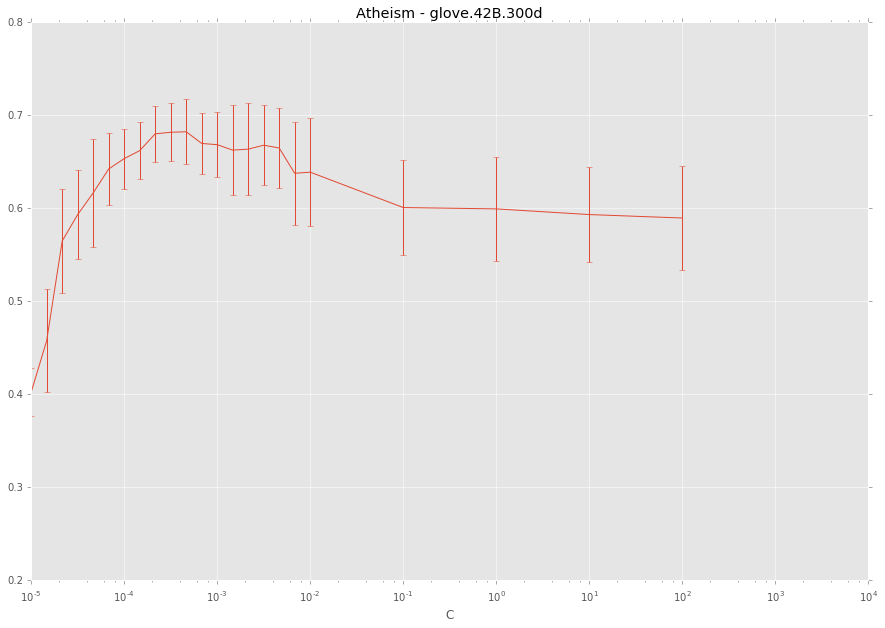

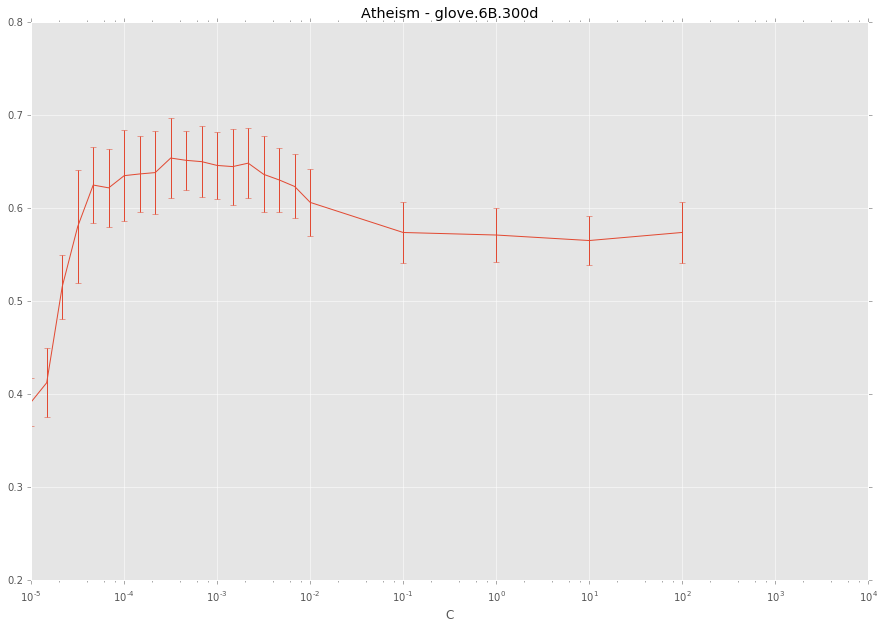

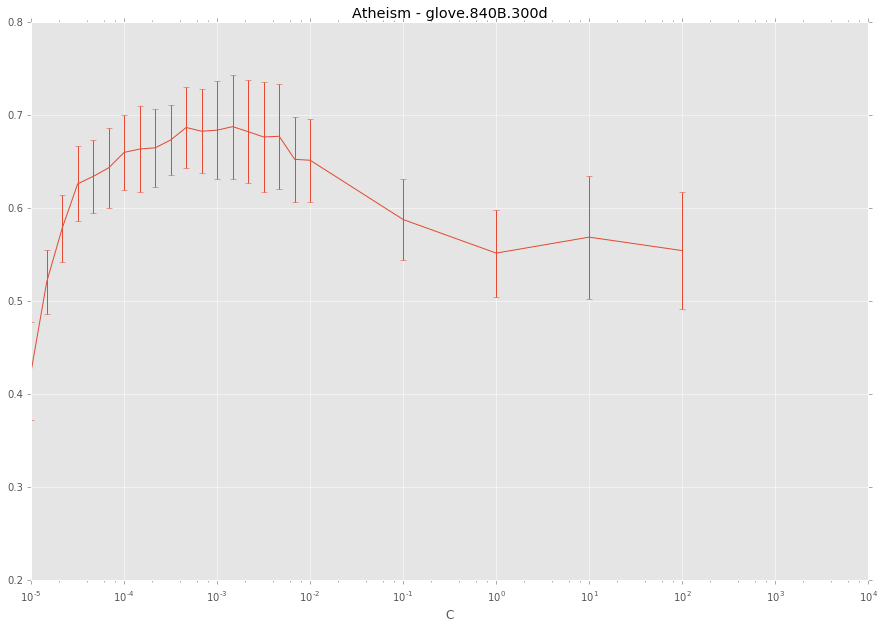

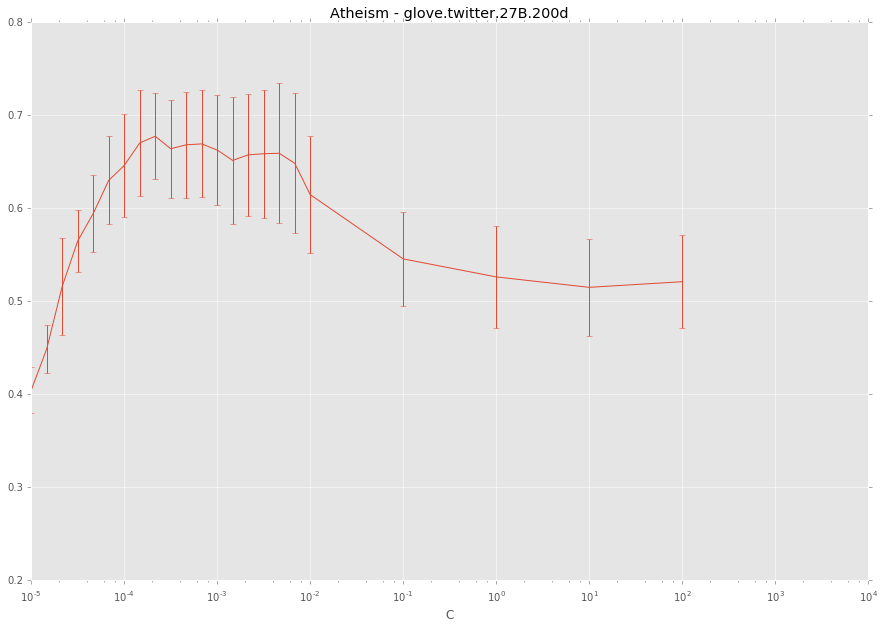

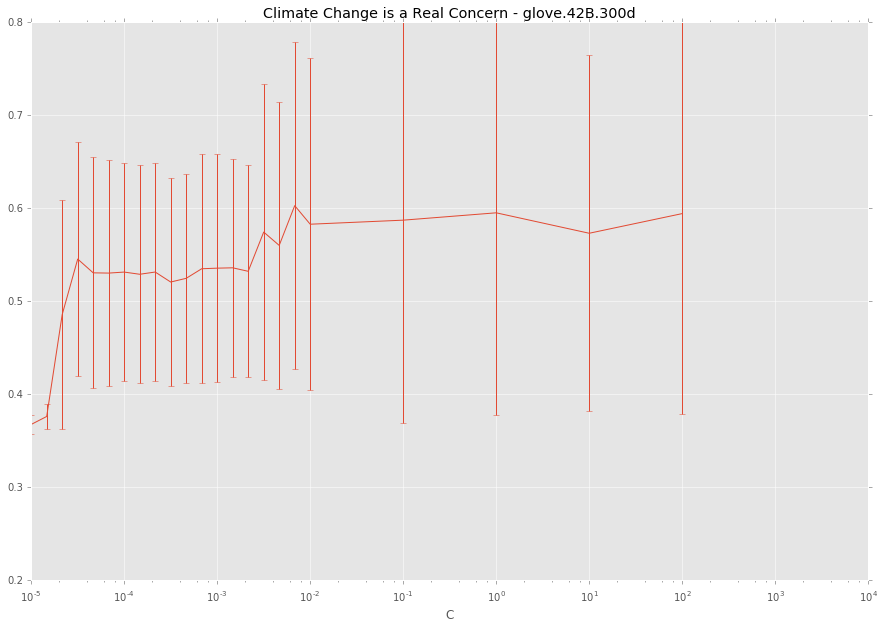

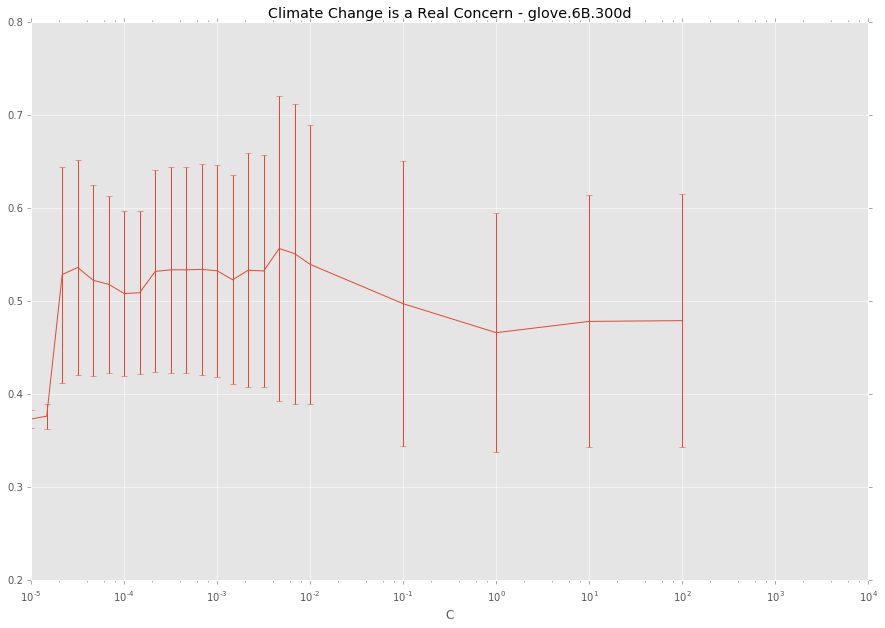

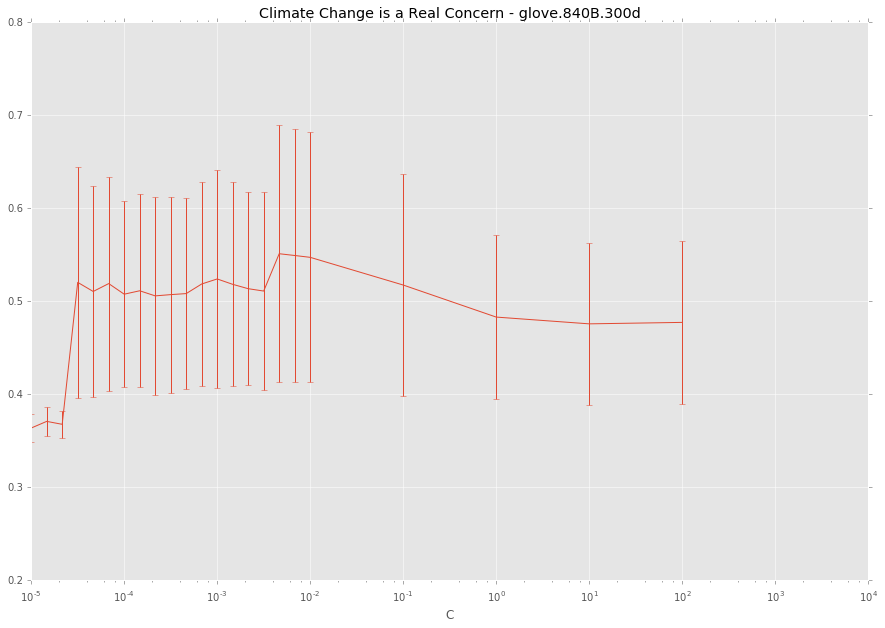

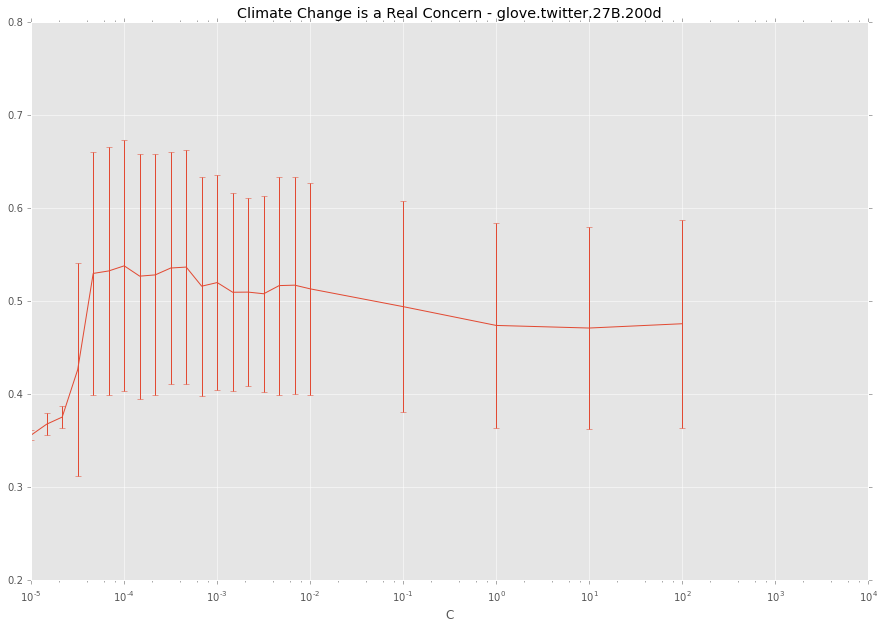

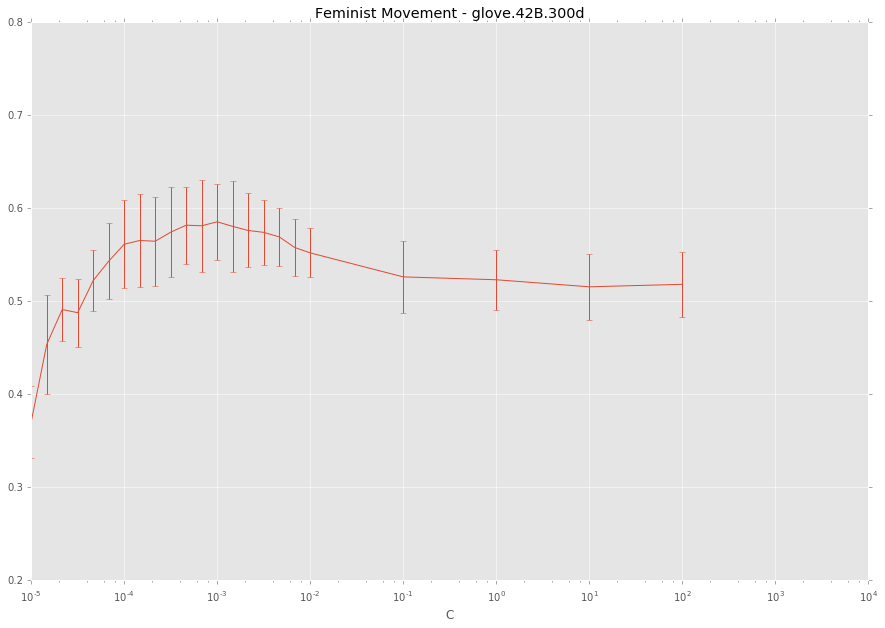

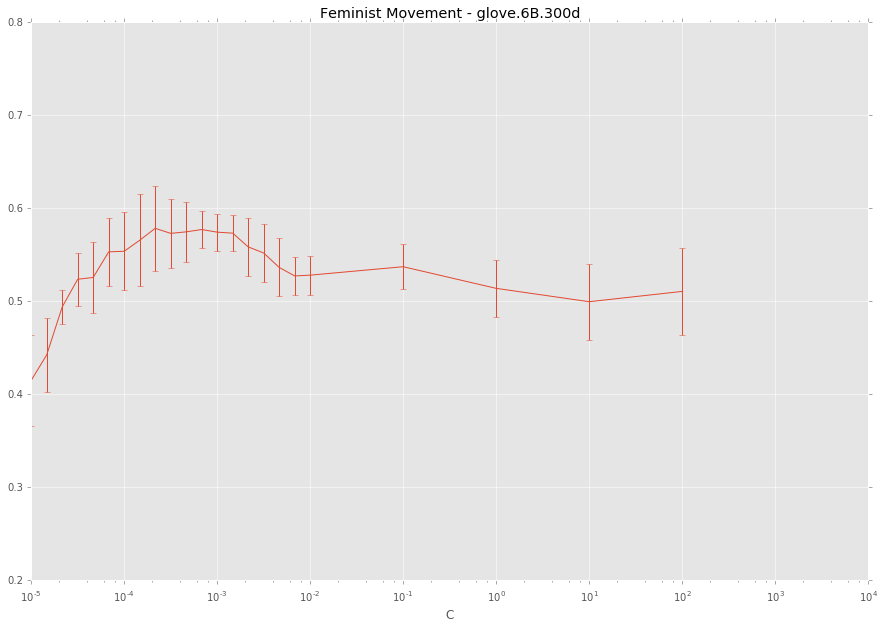

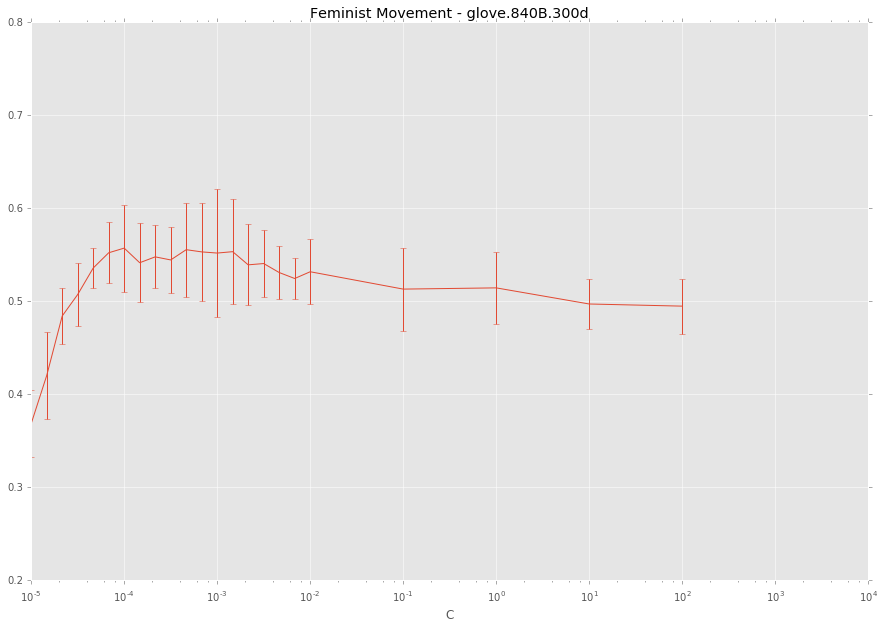

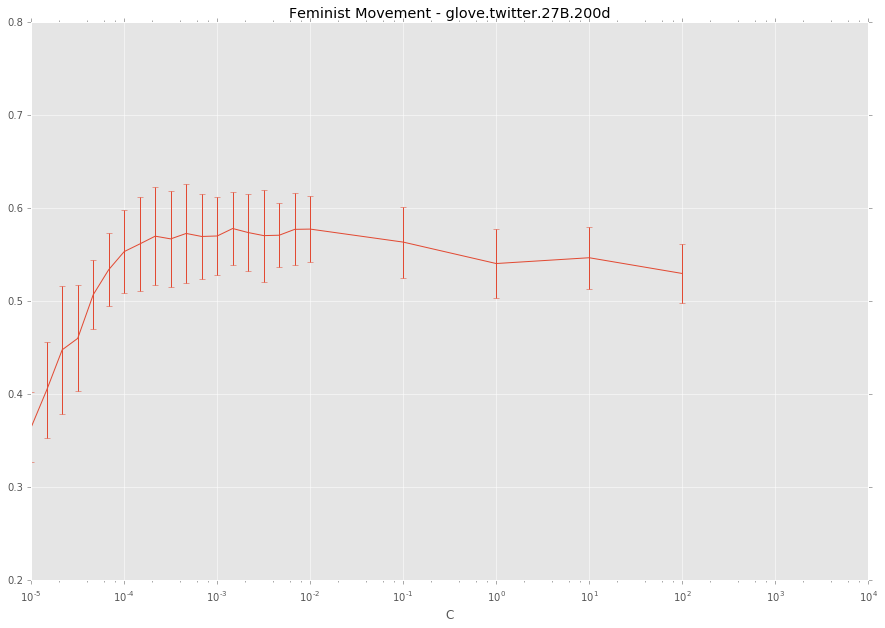

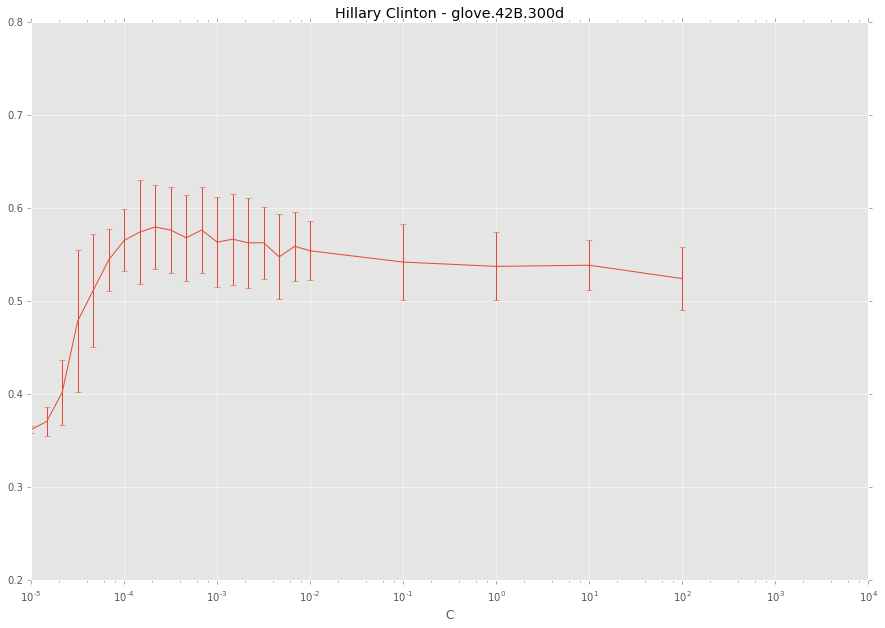

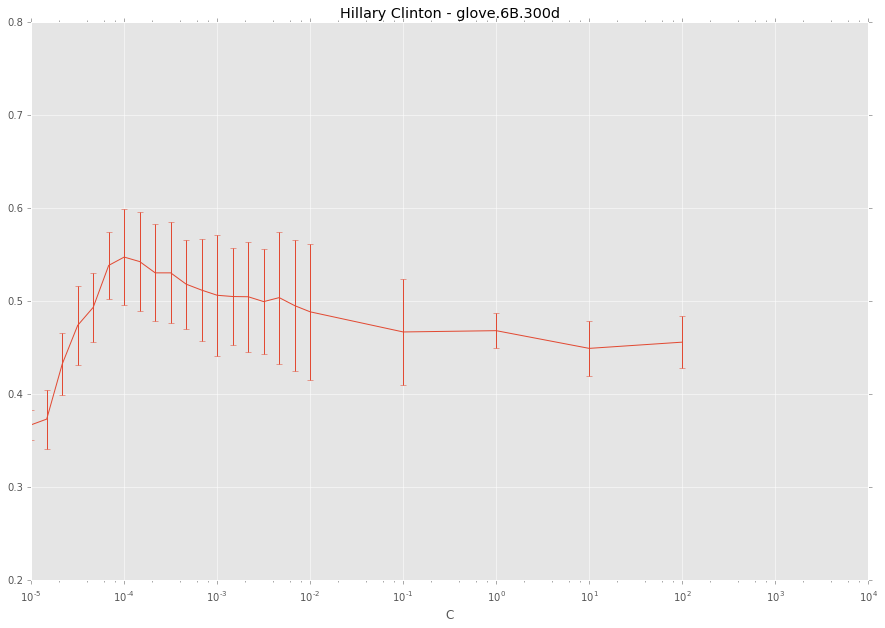

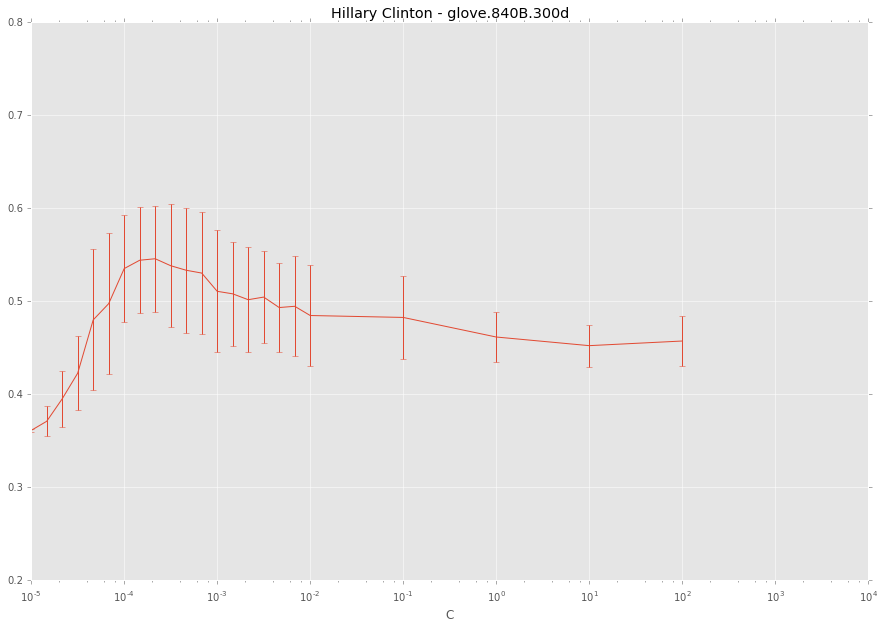

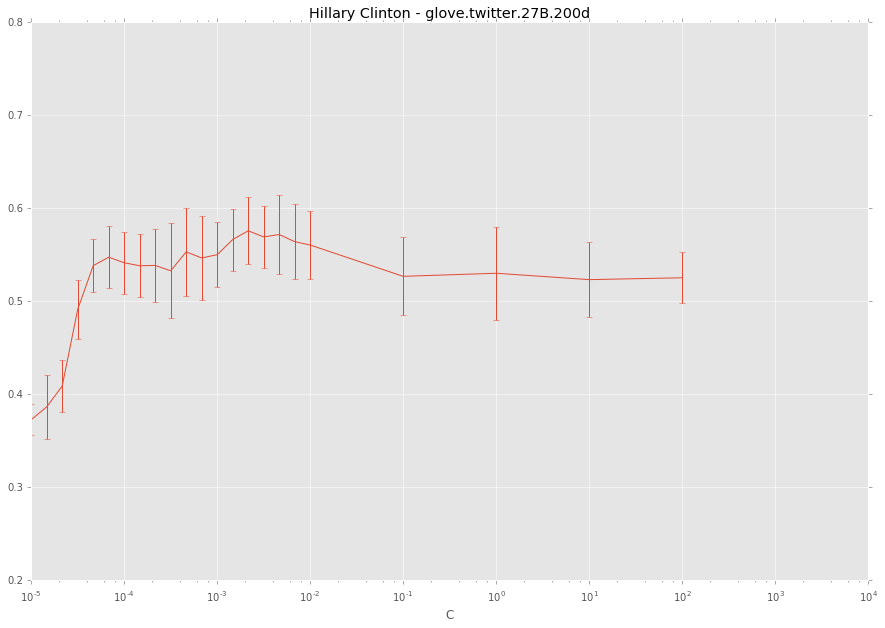

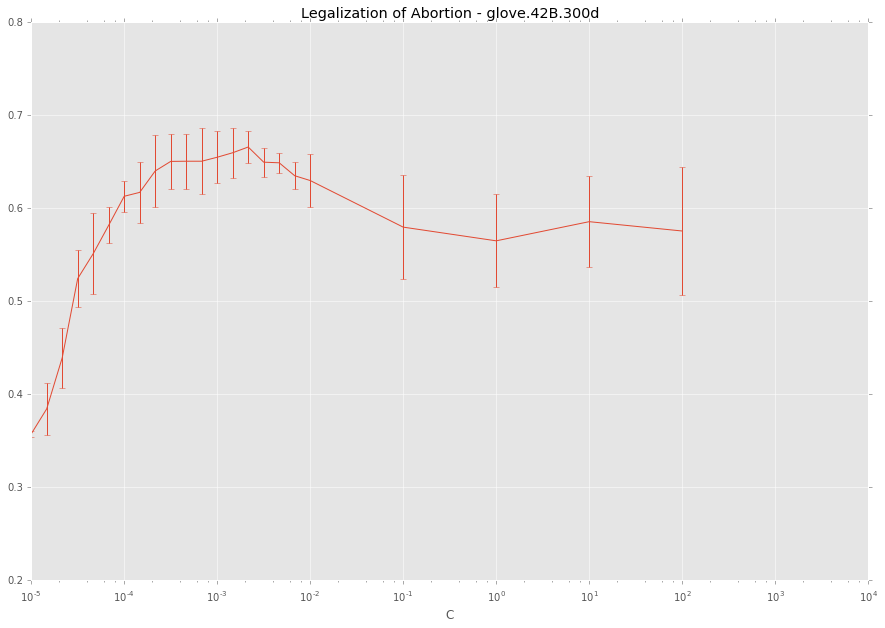

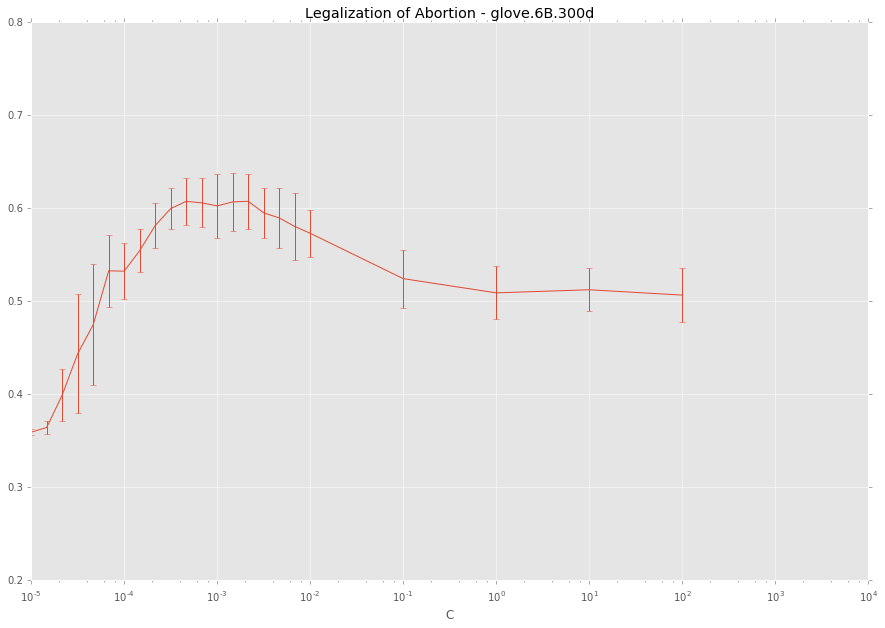

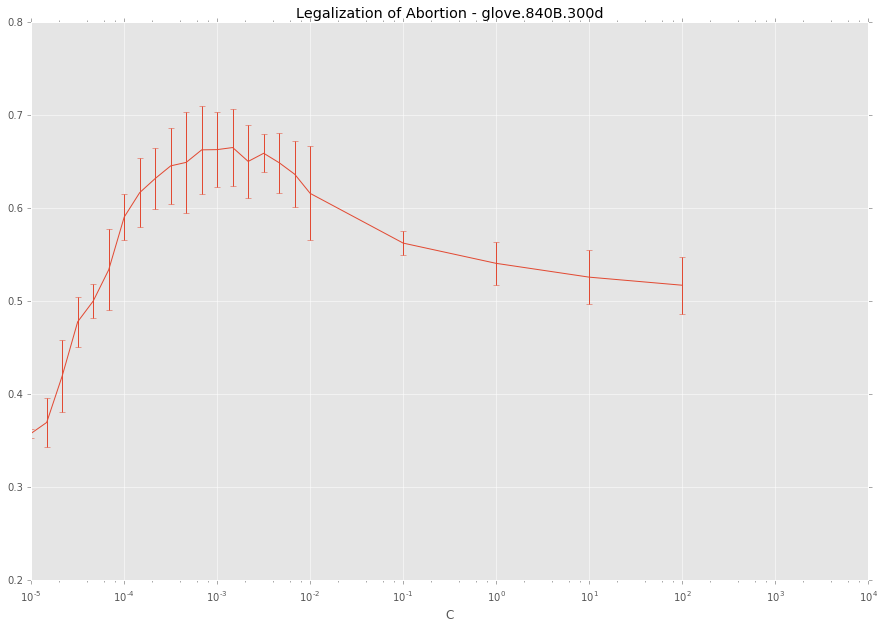

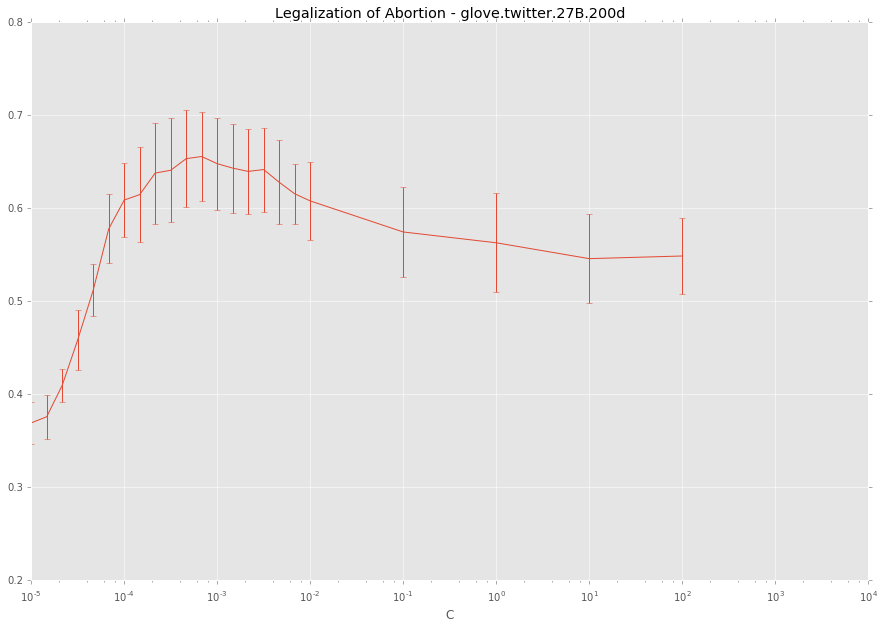

In [77]:
i = 0

for target in targets:
    print 80 * "="
    print target
    print 80 * "="
    
    target_data = data[data.Target == target] #if target != 'All' else data
    true_stances = target_data.Stance

    params = dict(
        SVC__C=np.hstack([
                np.logspace(-6,-2,25), 
                np.logspace(-1,2,4)])
        #SVC__C=np.logspace(-5,2,15)
        #SVC__C=[0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    )

    cv = StratifiedKFold(true_stances, n_folds=5, shuffle=True, random_state=7)


    for fname, glove_id in zip(glove_fnames, glove_ids):
        print 80 * '-'
        print 'GLOVE VECTORS:', glove_id
        print 80 * '-'

        glove_vecs = pd.read_pickle(fname)

        glove_clf = Pipeline([('vect', GloveVectorizer(glove_vecs)),
                              ('SVC', LinearSVC(class_weight='balanced'))])

        grid_search = GridSearchCV(glove_clf, params, scoring=macro_f_scorer, cv=cv)
        grid_search.fit(target_data.Tweet, true_stances)

        results = []

        for t in grid_search.grid_scores_:
            results.append((
                t.mean_validation_score,
                t.cv_validation_scores.std(),
                t.parameters['SVC__C']))

        results = pd.DataFrame(results, columns=['score_mean', 'score_std', 'C'])
        results.set_index('C', inplace=True)
        #results.sort_values(by='score_mean', inplace=True, ascending=False)
        print results

        fig, ax = plt.subplots()
        fig.set_size_inches((15,10))
        xlim = ((10e-6, 10e3))
        results['score_mean'].plot(ax=ax, yerr=results['score_std'], logx=True, ylim=(0.2,0.8), xlim=xlim, 
                                   title=target + ' - ' + glove_id)
        
        best, select, best_C, selected_C = select_C(results)
        table.iloc[i] = ( target, glove_id, 
                         best.score_mean, best.score_std, 
                         select.score_mean, select.score_std, 
                         best.score_mean - select.score_mean,
                         best.score_std - select.score_std,
                         best_C, selected_C )
        i += 1


In [78]:
table

,target,glove_id,best_mean,best_std,select_mean,select_std,mean_diff,std_diff,best_C,select_C
0,Atheism,glove.42B.300d,0.682488,0.035036,0.680265,0.029826,0.002222,0.005211,0.000464,0.000215
1,Atheism,glove.6B.300d,0.654231,0.042807,0.635290,0.049014,0.018940,-0.006207,0.000316,0.000100
2,Atheism,glove.840B.300d,0.688015,0.056030,0.660338,0.040454,0.027677,0.015576,0.001468,0.000100
3,Atheism,glove.twitter.27B.200d,0.677695,0.046419,0.670424,0.057088,0.007271,-0.010668,0.000215,0.000147
4,Climate Change is a Real Concern,glove.42B.300d,0.603037,0.175790,0.545609,0.126250,0.057428,0.049540,0.006813,0.000032
5,Climate Change is a Real Concern,glove.6B.300d,0.556992,0.164129,0.528926,0.116121,0.028067,0.048008,0.004642,0.000022
6,Climate Change is a Real Concern,glove.840B.300d,0.551340,0.138416,0.520553,0.123942,0.030787,0.014474,0.004642,0.000032
7,Climate Change is a Real Concern,glove.twitter.27B.200d,0.538318,0.135031,0.530167,0.130681,0.008152,0.004350,0.000100,0.000046
8,Feminist Movement,glove.42B.300d,0.585694,0.041045,0.565554,0.050206,0.020140,-0.009162,0.001000,0.000147
9,Feminist Movement,glove.6B.300d,0.578671,0.045956,0.565819,0.049470,0.012852,-0.003514,0.000215,0.000147


In [79]:
cPickle.dump(table, open('glove_svc_c_tuning.pkl', 'wb'))